### Import cac thu vien can thiet
1. Problem defind: detection lung cancer using CNN VGG16

In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd

### Import du lieu va tien su ly du lieu
dataset: from kaggle
- test represent testing set

- train represent training set

- valid represent validation set

- training set is 70%

- testing set is 20%

- validation set is 10%

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # chuyen tu du lieu anh sang du lieu tensor cho keras
train_data_gen = ImageDataGenerator(rescale = 1./255, # tranh over fit
                                   validation_split = 0.2, #tỷ lệ ảnh được giữ lại làm validation. Augmentation sẽ không được áp dụng cho validation set.
                                    rotation_range = 5, #Xoay ảnh góc 
                                    width_shift_range = 0.2, #Dịch theo chiều ngang ngẫu nhiên trong một phạm vi
                                    height_shift_range = 0.2 #Dịch theo cao ngẫu nhiên trong một phạm vi nào đó
                                   ) # chuan hoa du lieu giup thuan loi cho viec huan luyen
valid_data_gen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [3]:
train_data_set = train_data_gen.flow_from_directory(directory = "./Data/train",
                                                    target_size = (224,224), # size cua input dau vao,mỗi ảnh sẽ được resized theo kích thước này.
                                                    class_mode = "categorical", #
                                                    batch_size = 64 #Số lượng ảnh được yielded từ generator cho mỗi lô batch.
                                                   )

valid_data_set = train_data_gen.flow_from_directory(directory = "./Data/valid",
                                                    target_size = (224,224),
                                                    class_mode = "categorical",
                                                    batch_size = 64
                                                    )
test_data_set = train_data_gen.flow_from_directory(directory = "./Data/test",
                                                    target_size = (224,224),
                                                    class_mode = "categorical",
                                                    batch_size = 64
                                                    )

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


### Gan nhan du lieu va su dung CNN model VGG16

In [4]:
labels = ["adenocarcinoma","Large cell carcinoma","normal","Squamous cell carcinoma"]

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape = (224,224,3),
                   include_top = False, # bo phan softmax di,tu them cua minh vao
                  weights="imagenet")

In [6]:
# dong bang layer
for layer in base_model.layers:
    layer.trainable=False

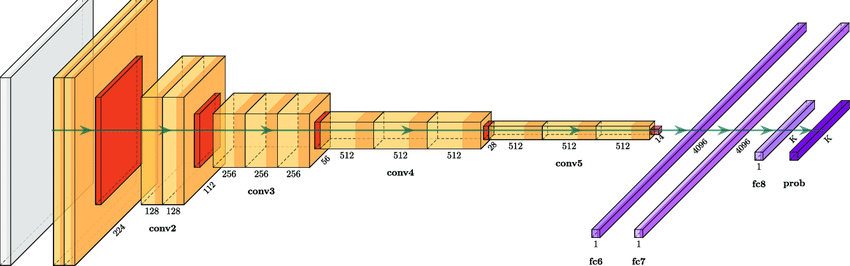

### xay dung model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Flatten,Dense,Activation,MaxPool2D,Conv2D,BatchNormalization

model = Sequential()
model.add(base_model)
model.add(Dropout(0.5)) # tranh overfiting du lieu hon loan
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer="he_uniform"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer="he_uniform"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer="he_uniform"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(4,activation="softmax"))


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [9]:
import keras.backend as K
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [10]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                                                                       tf.keras.metrics.Precision(name='precision'),
                                                                       tf.keras.metrics.Recall(name='recall'),  
                                                                      tf.keras.metrics.AUC(name='auc'),
                                                                        f1,])

In [11]:

%time
history = model.fit(train_data_set,
                   validation_data=valid_data_set,
                   epochs = 5,
                  verbose = 1)

Wall time: 0 ns
Epoch 1/5
10/10 [==============================] - 99s 10s/step - loss: 1.4690 - accuracy: 0.7325 - precision: 0.3771 - recall: 0.1077 - auc: 0.5661 - f1: 0.1664 - val_loss: 1.6495 - val_accuracy: 0.7257 - val_precision: 0.3939 - val_recall: 0.1806 - val_auc: 0.6185 - val_f1: 0.3395
Epoch 2/5
10/10 [==============================] - 100s 10s/step - loss: 1.3673 - accuracy: 0.7467 - precision: 0.4762 - recall: 0.1305 - auc: 0.6187 - f1: 0.2014 - val_loss: 1.1902 - val_accuracy: 0.7778 - val_precision: 0.6429 - val_recall: 0.2500 - val_auc: 0.7411 - val_f1: 0.4413
Epoch 3/5
10/10 [==============================] - 103s 10s/step - loss: 1.2966 - accuracy: 0.7573 - precision: 0.5500 - recall: 0.1615 - auc: 0.6688 - f1: 0.2494 - val_loss: 1.1870 - val_accuracy: 0.7847 - val_precision: 0.6667 - val_recall: 0.2778 - val_auc: 0.7125 - val_f1: 0.5111
Epoch 4/5
10/10 [==============================] - 102s 10s/step - loss: 1.2028 - accuracy: 0.7728 - precision: 0.6273 - recall: 0

In [12]:
#import ipywidgets as widgets

#uploader = widgets.FileUpload(multi=False)

In [13]:
#display(uploader)

In [14]:
#uploader.value.keys()
#for key in uploader.value.keys():
#    filename = key
#    print(filename)

1/1 [==============================] - 0s 161ms/step
[[0. 0. 1. 0.]]
normal


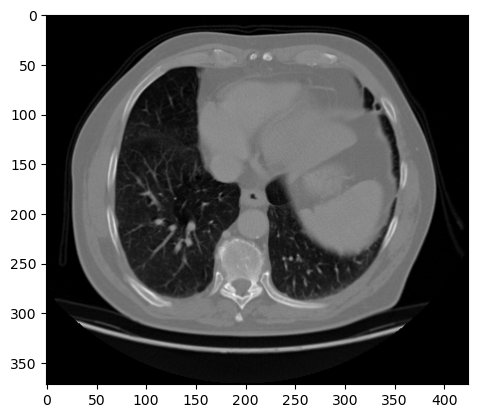

In [18]:
import matplotlib.image as mpimg
from tensorflow import keras
%matplotlib inline

#path = "./Data/test/"+filename
path = "./Data/test/000157 (6).png"
plt.imshow(mpimg.imread(path))

img=keras.preprocessing.image.load_img(path,target_size=(224,224))
x=keras.preprocessing.image.img_to_array(img)
x=np.expand_dims(x,axis=0)
images=np.vstack([x])
y_predict = model.predict(images,batch_size=10)

#print(filename)
print(y_predict)
print(labels[np.argmax(y_predict)])

In [16]:
#model.evaluate(test_data_set, verbose=1)